# Group Splitter

Train the group splitter with the updated pipeline structure.

In [1]:
from pathlib import Path
from pioneerml.common.evaluation.plots.loss import LossCurvesPlot
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import group_splitting_pipeline
PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Build aligned parquet/probability inputs.
# Expected prediction shard naming: ml_output_XXX_preds.parquet

data_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(data_dir.glob("ml_output_*.parquet"))
probs_dir = data_dir / "group_classifier"

# Example: uncomment to select a smaller subset
main_paths = main_paths[:1]

def _pick_group_classifier_preds(main_path: Path) -> Path | None:
    candidates = [
        probs_dir / f"{main_path.stem}_preds.parquet",
        probs_dir / f"{main_path.stem}_preds_latest.parquet",
    ]
    for c in candidates:
        if c.exists():
            return c
    return None

paired = []
missing_prob_paths = []
for main_path in main_paths:
    pred_path = _pick_group_classifier_preds(main_path)
    if pred_path is not None:
        paired.append((str(main_path.resolve()), str(pred_path.resolve())))
    else:
        missing_prob_paths.append(str((probs_dir / f"{main_path.stem}_preds.parquet").resolve()))

if not paired:
    raise RuntimeError(
        "No aligned parquet/prediction pairs found. "
        "Run group-classifier inference first to generate *_preds.parquet files."
    )
if missing_prob_paths:
    print(f"Warning: missing {len(missing_prob_paths)} prediction shard(s); skipping those files.")

parquet_paths = [p for p, _ in paired]
group_probs_parquet_paths = [p for _, p in paired]
print(f"Using {len(parquet_paths)} shard(s) for group-splitter training.")

Using 1 shard(s) for group-splitter training.


In [3]:
# Run the pipeline
base_loader_config = {
    "mode": "train",
    "use_group_probs": True,
    # "batch_size": 64,  # Optional: force a fixed batch size instead of HPO-selected
    "chunk_row_groups": 4,
    "chunk_workers": 0,
    "train_fraction": 0.80,
    "val_fraction": 0.10,
    "test_fraction": 0.10,
    "split_seed": 0,
}

pipeline_config = {
    "loader": {
        # Loader step validates source files and stores source paths.
        "config_json": {"mode": "train", "use_group_probs": True},
    },
    "hpo": {
        "enabled": True,
        "n_trials": 4,
        "max_epochs": 10,
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 2,
            "min_delta": 0.05,
            "min_delta_mode": "relative",
        },
        "compile": {"enabled": False, "mode": "reduce-overhead"},
        "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/group_splitter_hpo.db",
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": 0.125},
            "val": {"split": "val", "sample_fraction": 0.125},
        },
    },
    "train": {
        "max_epochs": 25,
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 5,
            "min_delta": 0.05,
            "min_delta_mode": "relative",
        },
        "compile": {"enabled": True, "mode": "reduce-overhead"},
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": None},
            "val": {"split": "val", "sample_fraction": None},
        },
    },
    "evaluate": {
        "threshold": 0.5,
        "loader_config": {
            "base": dict(base_loader_config),
            "evaluate": {"split": "test", "sample_fraction": None},
        },
    },
    "export": {
        "prefer_cuda": True,
        "export_dir": str(PROJECT_ROOT / "trained_models" / "groupsplitter"),
    },
}

run = group_splitting_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    group_probs_parquet_paths=group_probs_parquet_paths,
    pipeline_config=pipeline_config,
)


Initiating a new run for the pipeline: group_splitting_pipeline.
Caching is disabled by default for group_splitting_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_group_splitter_dataset has started.
Step load_group_splitter_dataset has finished in 0.145s.
Step tune_group_splitter has started.


[I 2026-02-18 23:16:28,760] Using an existing study with name 'group_splitter_hpo' instead of creating a new one.


[tune_group_splitter] GPU available: True (cuda), used: True
[tune_group_splitter] TPU available: False, using: 0 TPU cores
[tune_group_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_group_splitter] You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set torch.set_float32_matmul_precision('medium' | 'high') which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[tune_group_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupSplitter     │  316 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 316 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 316 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 21                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_group_splitter] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[tune_group_splitter] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[tune_group_splitter] Trainer.fit stopped: max_epochs=10 reached.


[I 2026-02-18 23:16:34,068] Trial 16 finished with value: 0.13819116755173758 and parameters: {'batch_size_exp': 5, 'heads': 7, 'hidden': 161, 'layers': 1, 'dropout': 0.157669435590424, 'lr': 0.00035328954885953027, 'weight_decay': 1.2294261828083063e-06}. Best is trial 13 with value: 0.07550949452874753.


[tune_group_splitter] GPU available: True (cuda), used: True
[tune_group_splitter] TPU available: False, using: 0 TPU cores
[tune_group_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_group_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupSplitter     │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 37                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-18 23:16:37,481] Trial 17 finished with value: 0.09549660536532219 and parameters: {'batch_size_exp': 5, 'heads': 6, 'hidden': 210, 'layers': 2, 'dropout': 0.18289837947547796, 'lr': 0.0005285412686526853, 'weight_decay': 5.709491043172706e-05}. Best is trial 13 with value: 0.07550949452874753.


[tune_group_splitter] GPU available: True (cuda), used: True
[tune_group_splitter] TPU available: False, using: 0 TPU cores
[tune_group_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_group_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupSplitter     │  259 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 259 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 259 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 53                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-18 23:16:40,924] Trial 18 finished with value: 0.07748139155312227 and parameters: {'batch_size_exp': 5, 'heads': 7, 'hidden': 84, 'layers': 3, 'dropout': 0.12996575850748232, 'lr': 0.0016781382835266317, 'weight_decay': 0.00029824335104153504}. Best is trial 13 with value: 0.07550949452874753.


[tune_group_splitter] GPU available: True (cuda), used: True
[tune_group_splitter] TPU available: False, using: 0 TPU cores
[tune_group_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_group_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupSplitter     │  107 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 107 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 107 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 37                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-18 23:16:45,708] Trial 19 finished with value: 0.09695183672010899 and parameters: {'batch_size_exp': 5, 'heads': 6, 'hidden': 66, 'layers': 2, 'dropout': 0.13440195132356053, 'lr': 0.0018182932754983315, 'weight_decay': 0.0003836384645134266}. Best is trial 13 with value: 0.07550949452874753.


Step tune_group_splitter has finished in 17.114s.
Step train_group_splitter has started.
[train_group_splitter] GPU available: True (cuda), used: True
[train_group_splitter] TPU available: False, using: 0 TPU cores
[train_group_splitter] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[train_group_splitter] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ OptimizedModule   │  1.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 38                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[train_group_splitter] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_group_splitter] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



[train_group_splitter] No materializer is registered for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_group_splitter has finished in 53.805s.
Step evaluate_group_splitter has started.
Step evaluate_group_splitter has finished in 1.307s.
Step export_group_splitter has started.
Step export_group_splitter has finished in 0.775s.
Pipeline run has finished in 1m17s.


hpo_params: {'lr': 0.0019449013748355807, 'weight_decay': 0.00012738353730206654, 'batch_size': 32, 'study_name': 'group_splitter_hpo', 'storage': 'sqlite:////workspace/.optuna/group_splitter_hpo.db', 'model': {'in_channels': 4, 'prob_dimension': 3, 'hidden': 234, 'heads': 6, 'layers': 2, 'dropout': 0.16804180946449349}}
train_epoch_loss_history: [0.12618919699105938, 0.06771050379525957, 0.05123261290835742, 0.051399889928569566, 0.0457697016989193, 0.04354189621493033, 0.04232059259740086, 0.04105717647113134, 0.03969397381073004]
val_epoch_loss_history: [0.7876140475273132, 0.06734567089956633, 0.06493001845570243, 0.05416913722090575, 0.05052012281150234, 0.0503990321743245, 0.052672701374608645, 0.04977069582257952, 0.048233436876717876, 0.04990900216662154]
train_step_count: 873
val_step_count: 119
metrics: {'loss': 0.05941136022657678, 'accuracy': 0.9871525168418884, 'exact_match': 0.9716888666152954, 'confusion': [{'tp': 0.9783829309376755, 'fp': 0.011229646266142616, 'fn': 0.0

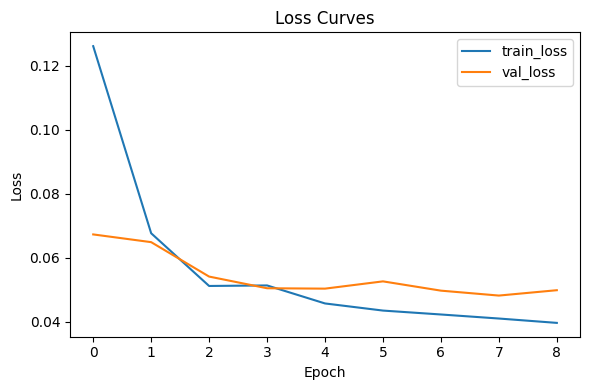

In [4]:
trained_module = load_step_output(run, "train_group_splitter")
hpo_params = load_step_output(run, "tune_group_splitter")
metrics = load_step_output(run, "evaluate_group_splitter")
export = load_step_output(run, "export_group_splitter")

print("hpo_params:", hpo_params)
if trained_module is not None:
    print("train_epoch_loss_history:", list(trained_module.train_epoch_loss_history))
    print("val_epoch_loss_history:", list(trained_module.val_epoch_loss_history))
    print("train_step_count:", len(trained_module.train_loss_history))
    print("val_step_count:", len(trained_module.val_loss_history))
print("metrics:", metrics)
print("export:", export)

# Plot loss curves
if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")
LossCurvesPlot().render(trained_module, show=True)
